## setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *; __version__

'1.0.32'

In [3]:
path = Config.data_path()/'aircraft'

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/aircraft/rafale'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f4'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f15c'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/mig21'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/su17'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f16'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f18c'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/typhoon'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/su27'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f15e'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/jas39'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f18e'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/f35'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/su24'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/su34'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/su25'),
 PosixPath('/home/jupyter/.fastai/data/aircraft/mig29'),
 PosixPath('/home/jupyter/.fastai/data/aircr

## data

In [4]:
src = (ImageItemList.from_folder(path)
       .random_split_by_pct(0.2)
       .label_from_folder())

In [5]:
bs = 64; size = 224
tfms = get_transforms()

In [6]:
data = (src.transform(get_transforms(), size=size)
           .databunch().normalize(imagenet_stats))

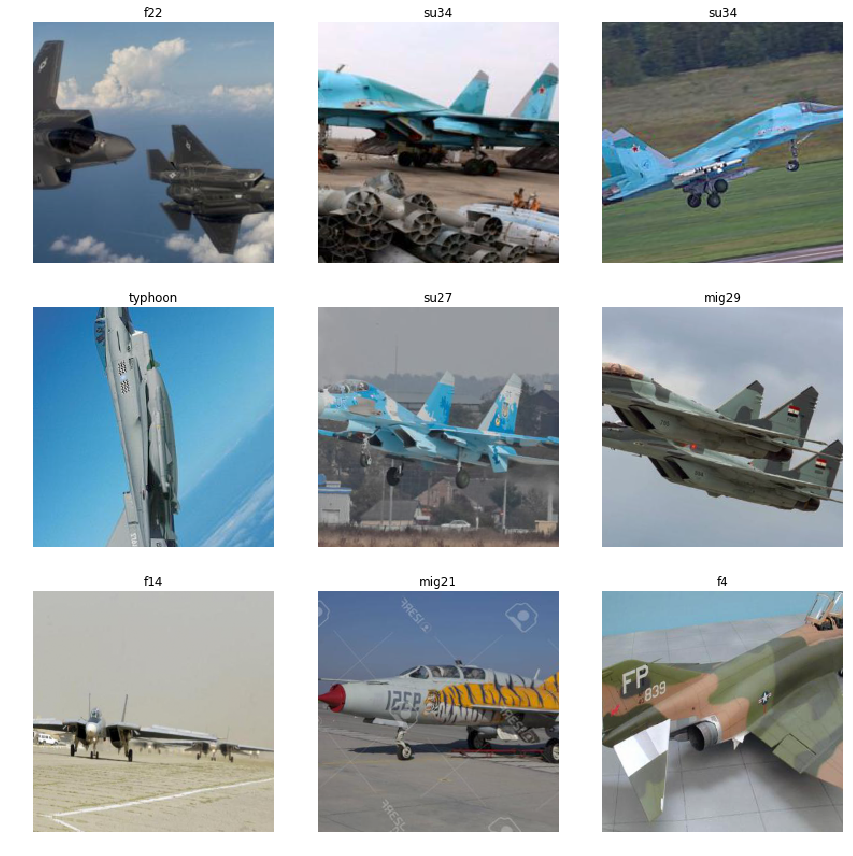

In [15]:
data.show_batch(rows=3)

## resnet50 model training

In [7]:
arch = models.resnet50

In [8]:
learn = create_cnn(data, arch, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


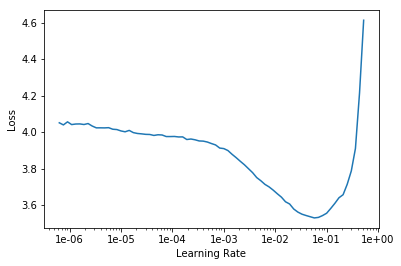

In [139]:
learn.lr_find(); learn.recorder.plot()

In [140]:
lr = 1e-2

In [141]:
learn.fit_one_cycle(6,lr)

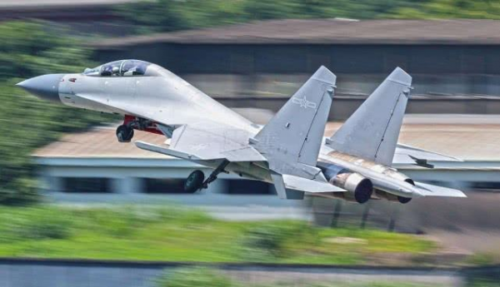

In [72]:
data.valid_ds.x[5]

In [60]:
data.valid_ds.x.items

array([PosixPath('/home/jupyter/.fastai/data/aircraft/su57/00000268.jpg'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/su34/00000238.jpeg'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/su25/00000181.jpg'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/f18c/00000217.jpg'), ...,
       PosixPath('/home/jupyter/.fastai/data/aircraft/mig29/00000245.png'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/su30/00000091.jpg'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/mig23/00000100.jpg'),
       PosixPath('/home/jupyter/.fastai/data/aircraft/f18c/00000142.JPG')], dtype=object)

In [61]:
np.random.choice(data.valid_ds.x.items)

PosixPath('/home/jupyter/.fastai/data/aircraft/mig29/00000177.jpg')

In [20]:
def get_random(data, dstype=DatasetType.Valid):
    if dstype == DatasetType.Valid:
        idx = np.random.randint(0,high=len(data.valid_ds))
        img = data.valid_ds.x[idx]
        ans = data.valid_ds.y[idx]
    else:
        idx = np.random.randint(0,high=len(data.train_ds))
        img = data.train_ds.x[idx]
        ans = data.train_ds.y[idx]
    
    return img, ans

pred / actual: f14 / f14


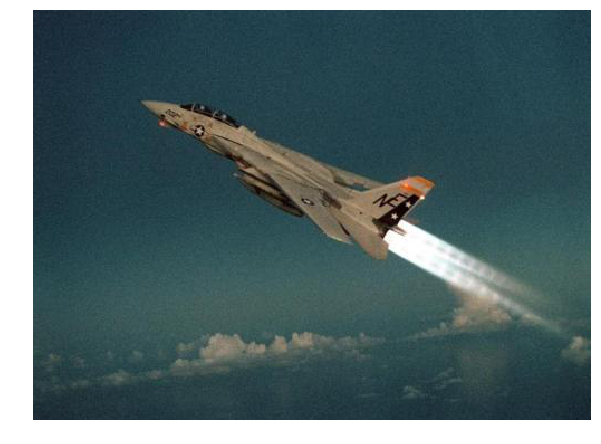

In [158]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

In [159]:
learn.save('fighterjet-rn50-01')

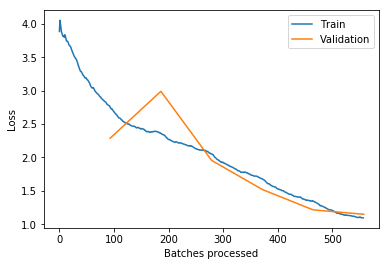

In [160]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


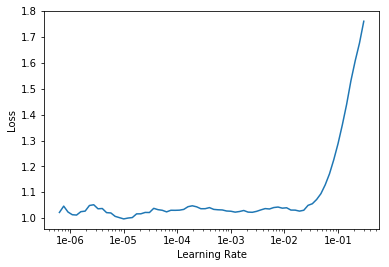

In [161]:
learn.lr_find(); learn.recorder.plot()

In [9]:
learn = create_cnn(data, arch, metrics=[accuracy])
learn.load('fighterjet-rn50-01');

In [10]:
learn.data.batch_size = 12 # out of memory above this

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


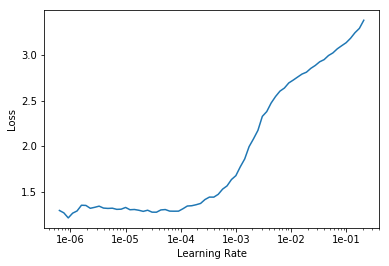

In [12]:
learn.lr_find(); learn.recorder.plot()

If CUDA out of memory: Run this

In [181]:
# del learn
# gc.collect()

8

I think J.Howard accidentally discovered that `e` is a good dividing factor between layer groups so I'm using lr/e^2, lr/e, lr:

In [13]:
lr = 1e-4

In [14]:
np.e

2.718281828459045

In [15]:
lrs = slice(lr/(np.e**2), lr)

In [16]:
lr/np.e

3.678794411714424e-05

In [17]:
learn.lr_range(lrs)

array([1.353353e-05, 3.678794e-05, 1.000000e-04])

In [18]:
learn.fit_one_cycle(6, lrs)

pred / actual: jas39 / jas39


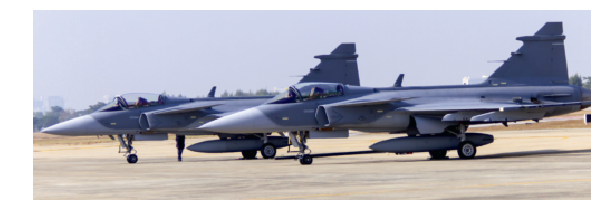

In [187]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: jas39 / tornado


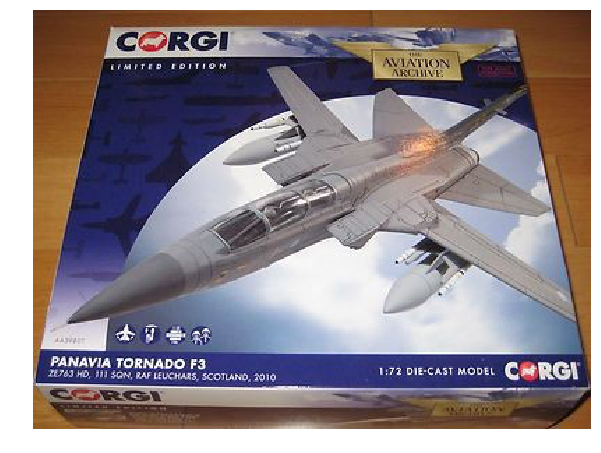

In [38]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

In [46]:
torch.topk(pred[2], 5)

(tensor([0.2562, 0.1838, 0.1694, 0.1355, 0.0547]),
 tensor([10, 25,  3,  4,  2]))

In [63]:
np.array(learn.data.classes)[top5[1]]

array(['jas39', 'tornado', 'f16', 'f18c', 'f15e'], dtype='<U7')

In [94]:
top5 = torch.topk(pred[2], 5)
pred_classes = np.array(learn.data.classes)[top5[1]]
colors = [('darkblue','firebrick')[y.data == p] for p in top5[1]]

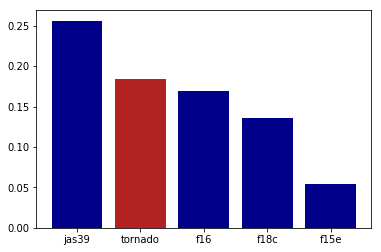

In [95]:
plt.xticks(range(5), np.array(learn.data.classes)[top5[1]])
plt.bar(range(len(top5[0])), top5[0], color=colors);

In [122]:
def display_probs(pred, y):
    if type(y) == Category: y=y.data
    top5 = torch.topk(pred[2], 5)
    pred_classes = np.array(learn.data.classes)[top5[1]]
    colors = [('darkblue','firebrick')[y == p] for p in top5[1]]
    plt.xticks(range(5), np.array(learn.data.classes)[top5[1]])
    plt.bar(range(len(top5[0])), top5[0], color=colors)
    

pred / actual: j20 / j20


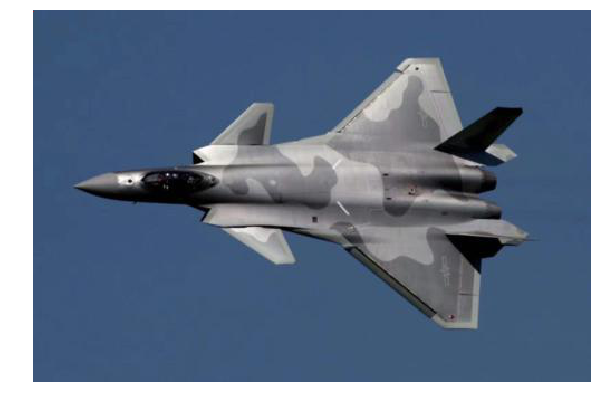

In [101]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

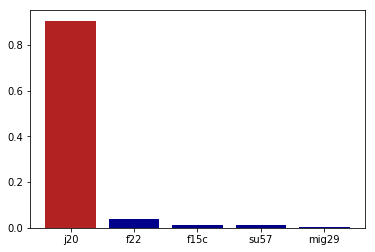

In [102]:
display_probs(pred, y)

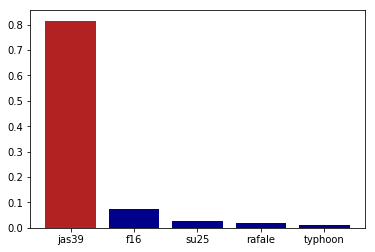

pred / actual: jas39 / jas39


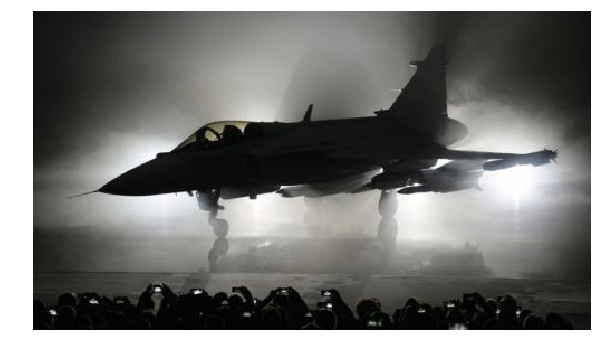

In [105]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

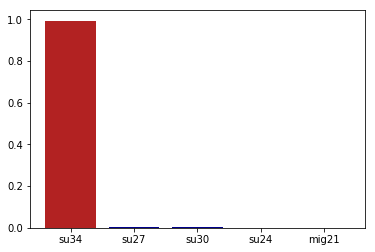

pred / actual: su34 / su34


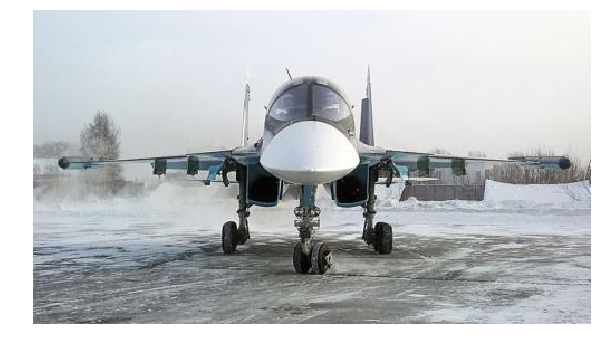

In [106]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

## testing on random screengrabs from youtube:

In [107]:
test_img_path = 'fighterjet/testimages/Screenshot 2018-12-13 21.27.39.png'

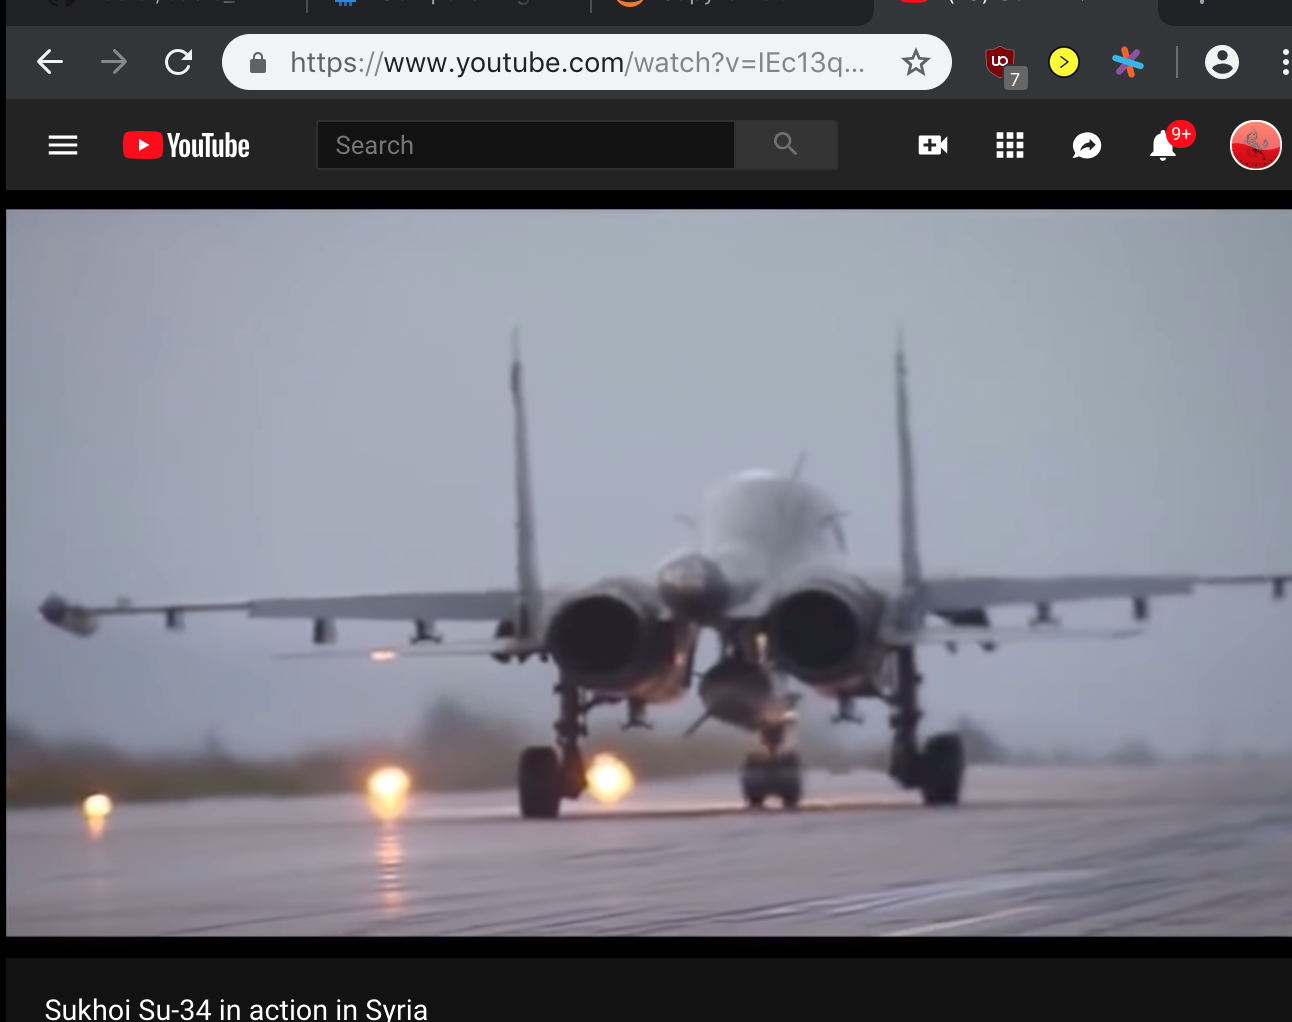

In [108]:
open_image(test_img_path)

In [114]:
type(pred[0])

fastai.core.Category

pred / actual: f14 / 23


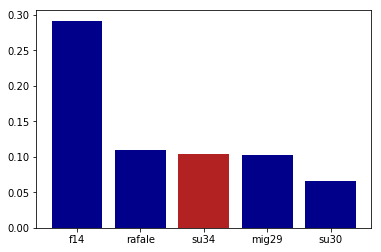

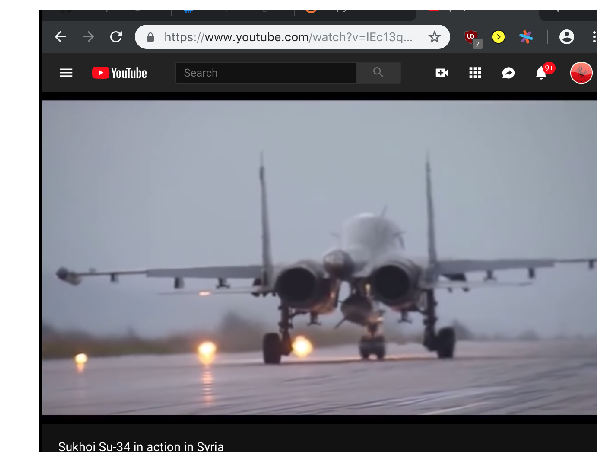

In [137]:
img = open_image(test_img_path)
pred = learn.predict(img)
y = learn.data.y.c2i['su34']

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

In [138]:
img2 = open_image('fighterjet/testimages/Screenshot 2018-12-13 21.36.12.png')
img3 = open_image('fighterjet/testimages/Screenshot 2018-12-13 21.36.22.png')

pred / actual: f16 / 22


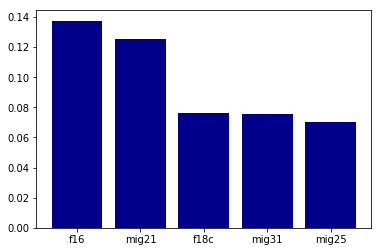

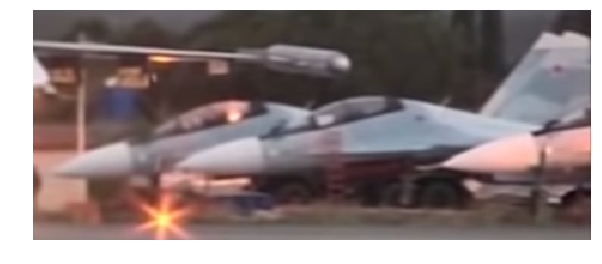

In [142]:
img = img2
pred = learn.predict(img)
y = learn.data.y.c2i['su30']

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: su34 / 23


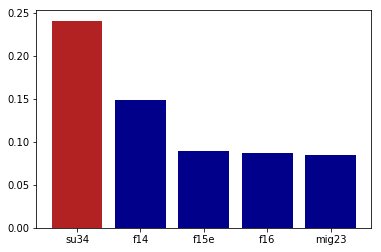

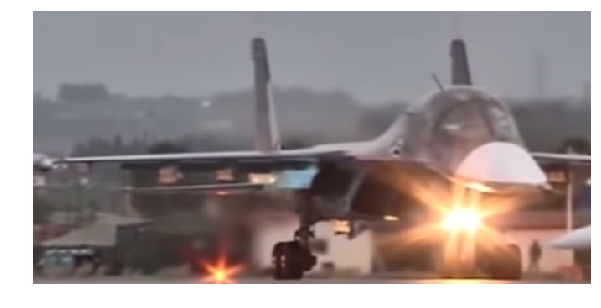

In [144]:
img = img3
pred = learn.predict(img)
y = learn.data.y.c2i['su34']

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

## further training

In [188]:
learn.freeze()

In [189]:
learn.save('fighterjet-rn50-01-stg2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


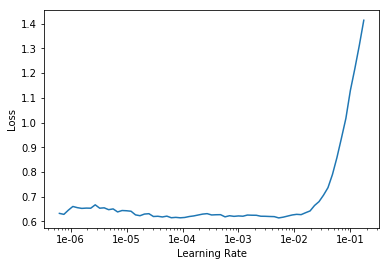

In [190]:
learn.data.batch_size = 64
learn.lr_find(); learn.recorder.plot()

In [191]:
lr = 1e-4

In [192]:
learn.fit_one_cycle(10, lr)

In [193]:
learn.save('fighterjet-rn50-02a')

In [195]:
learn.load('fighterjet-rn50-01-stg2');

In [196]:
learn.fit_one_cycle(5, lr)

In [197]:
learn.save('fighterjet-rn50-02b')

In [198]:
learn.fit_one_cycle(4,lr/10)

extra training did not help

## random test (valid) images

In [200]:
learn.load('fighterjet-rn50-02b');

pred / actual: f22 / f22


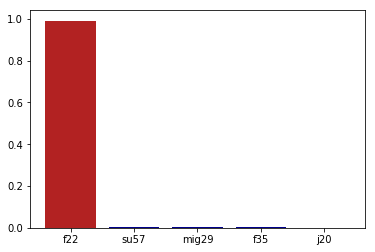

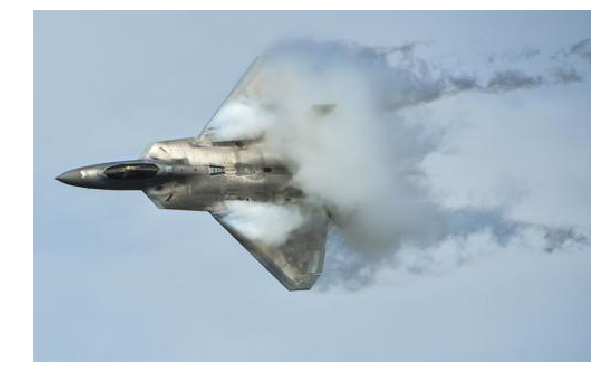

In [201]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: su24 / su24


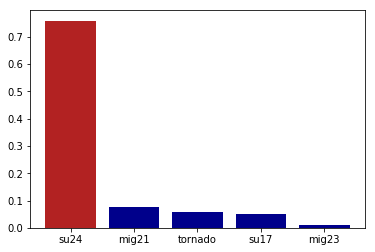

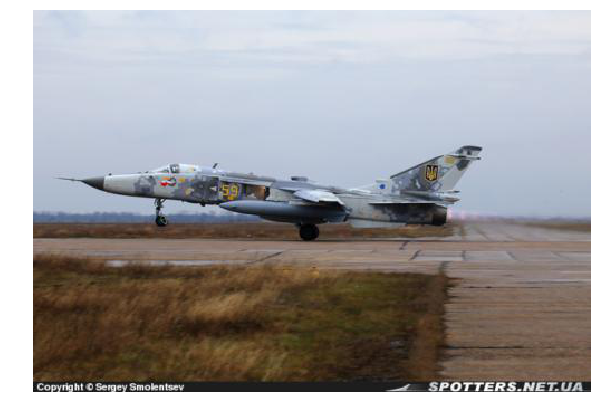

In [202]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: f22 / f22


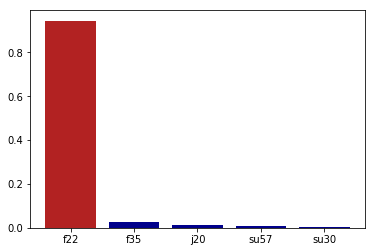

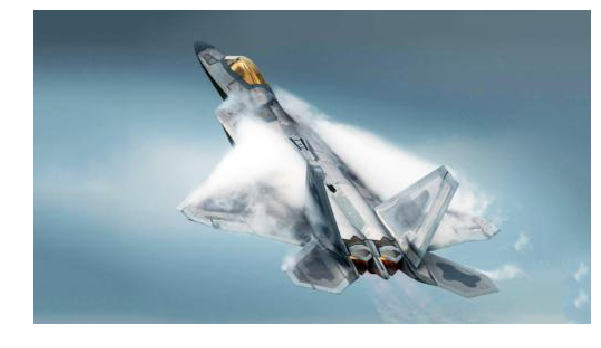

In [204]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: f18c / f18c


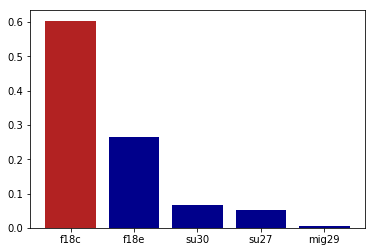

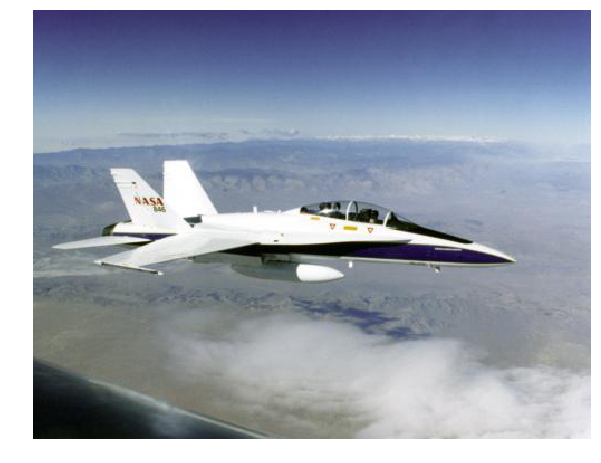

In [205]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: su17 / su17


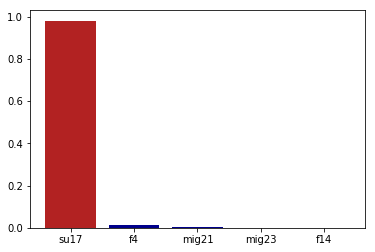

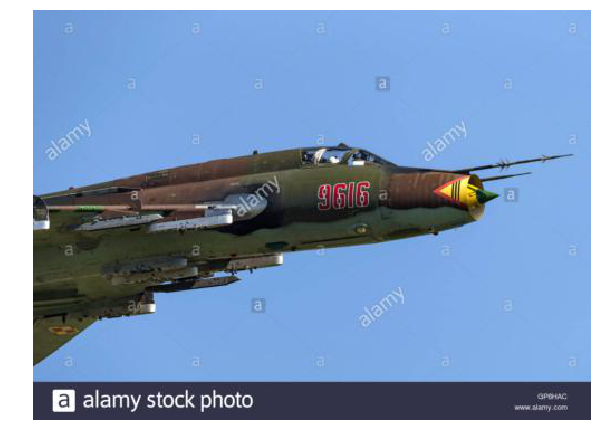

In [206]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: mig25 / mig25


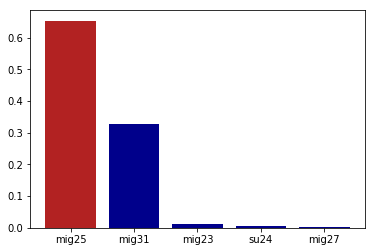

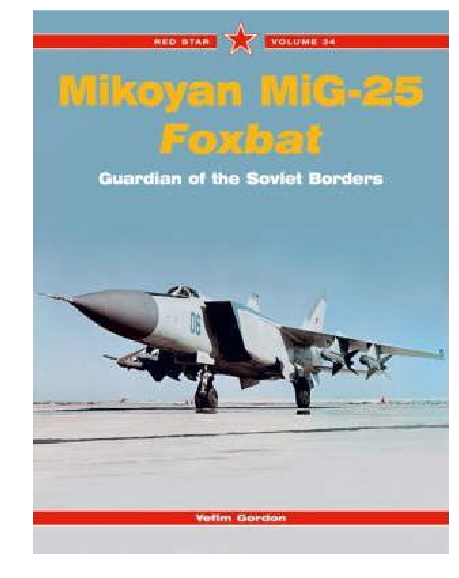

In [207]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: f15c / f15e


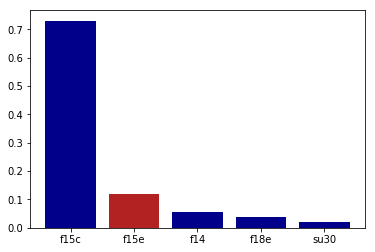

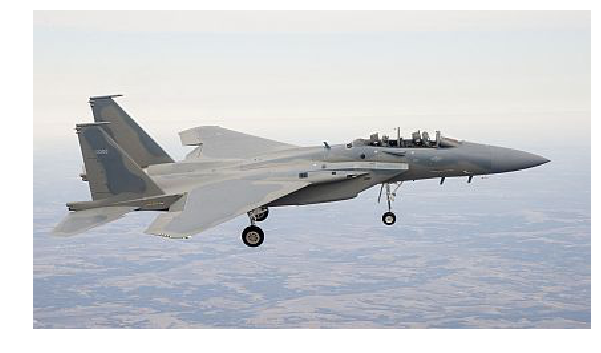

In [208]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

This F15E has an F15C's paint scheme, and also seems to be missing the conformal fuel tanks you always see on Strike Eagles. This is the first time I've seen it like this. You can tell it's an E-model since it has two seats.

...Or maybe it's a trainer version of the C.

pred / actual: mig29 / mig29


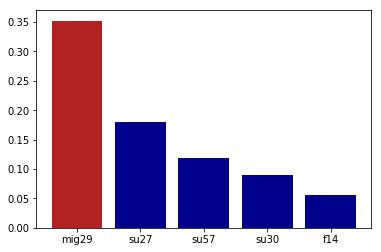

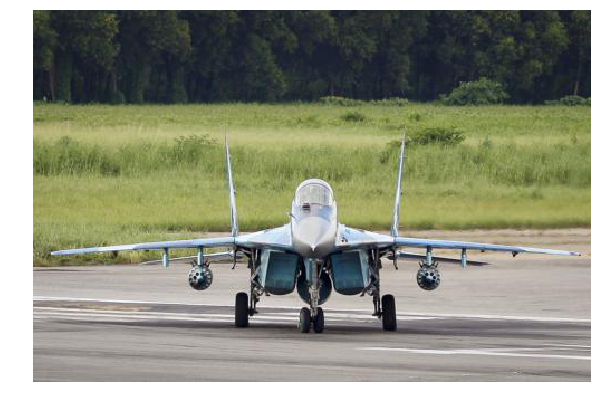

In [209]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: j20 / j20


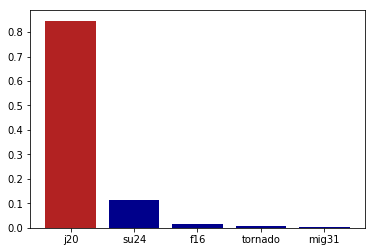

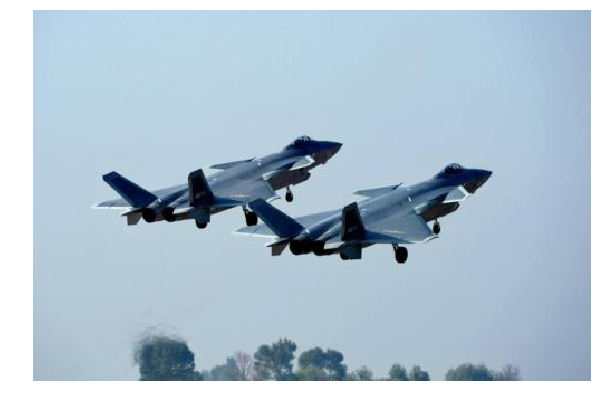

In [210]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

pred / actual: f22 / mig29


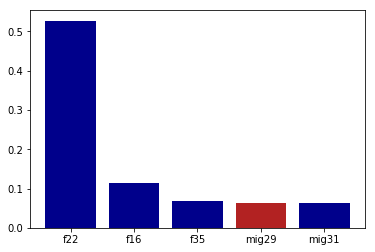

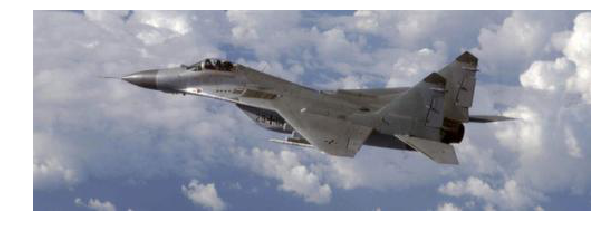

In [211]:
img, y = get_random(data, dstype=DatasetType.Valid)
pred = learn.predict(img)

display_probs(pred, y)
Image.show(img, figsize=(10,10))
print(f'pred / actual: {pred[0]} / {y}')

## interpretation & checking data

In [212]:
interp = ClassificationInterpretation.from_learner(learn)

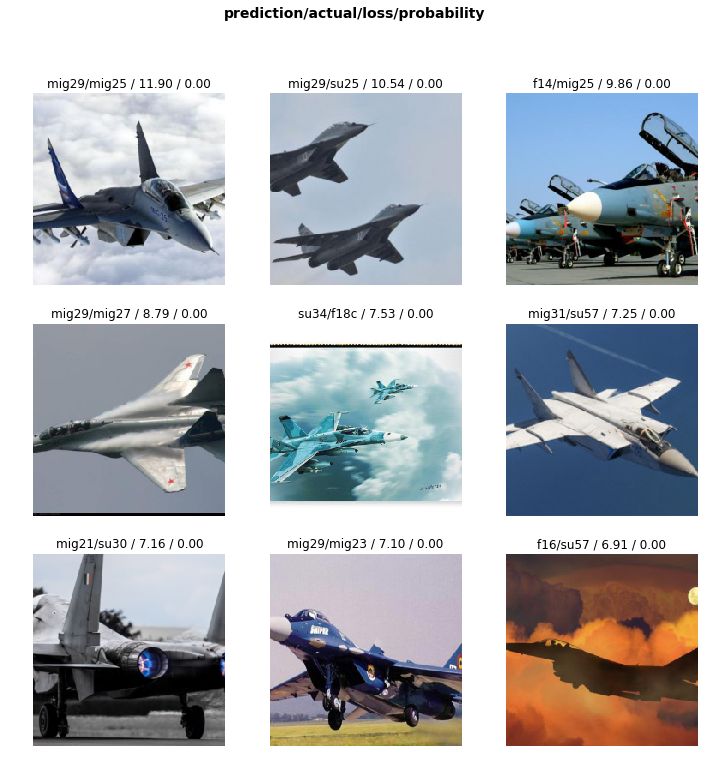

In [217]:
interp.plot_top_losses(9)

I think the **prediction/actual** label is reversed.

Some of these are silly, some I understand. The red/orange one is very similar to an su57 image except for the actual aircraft. The 'aggressor' paint scheme of the center f18c's is that of the su34. The others, I don't know.

In [218]:
interp.most_confused()

[('f15c', 'f15e', 11),
 ('f18c', 'f18e', 11),
 ('f15e', 'f15c', 10),
 ('f18e', 'f18c', 10),
 ('mig27', 'mig23', 7),
 ('mig31', 'mig25', 7),
 ('su27', 'su30', 7),
 ('mig23', 'mig27', 5),
 ('mig27', 'mig29', 5),
 ('j20', 'f22', 4),
 ('mig27', 'mig21', 4),
 ('f35', 'f22', 3),
 ('f4', 'f14', 3),
 ('jas39', 'f18c', 3),
 ('mig25', 'mig29', 3),
 ('rafale', 'typhoon', 3),
 ('su30', 'su27', 3),
 ('su57', 'mig31', 3),
 ('f15e', 'f18c', 2),
 ('f16', 'f14', 2),
 ('f16', 'f18c', 2),
 ('f16', 'rafale', 2),
 ('f18c', 'f16', 2),
 ('f18c', 'su24', 2),
 ('f18e', 'f15c', 2),
 ('j20', 'f4', 2),
 ('mig21', 'su17', 2),
 ('mig23', 'mig25', 2),
 ('mig23', 'su17', 2),
 ('mig25', 'jas39', 2),
 ('mig25', 'mig31', 2),
 ('mig27', 'mig31', 2),
 ('mig29', 'f16', 2),
 ('mig29', 'f22', 2),
 ('mig29', 'su57', 2),
 ('mig29', 'tornado', 2),
 ('mig31', 'j20', 2),
 ('mig31', 'jas39', 2),
 ('su27', 'mig29', 2),
 ('su30', 'jas39', 2),
 ('su30', 'mig21', 2),
 ('su34', 'mig29', 2),
 ('su34', 'su30', 2),
 ('su57', 'j20', 2),
 (

First column is actual, second is predicted.

Planes that are variants of each other:

F15C with F15E, and FA18(A-C) with FA18(E-F). The Mig27 and Mig23 are also ground attack and air-combat variants of each other. As are the Su27 and Su34. The Su27 and Su30 are also variants, and *very* similar looking aircraft. The Ukrainian Su27 trainer: I can't yet tell it apart from an Su30, aside from the fact that Ukraine doesn't have any Su30's, so the markings are the give away for me (and possibly the model).

The mig29 seems to be mistaken for a lot of other things, so that dataset may need additions and cleaning.

According to this, the model is more than 90% accurate for 20/27 classes, and at least 80% accurate for all classes. The model is at least 80% accurate in classifying aircraft that are *very* similar variants of each other (F15 C&E, FA18 A-C&E-F, Mig23&Mig27, Mig25&Mig31.

If I were doing a 'real' system, I'd want a dataset of 2-degree increment poses in all 3 axes for each aircraft. It'd be a huge dataset (180^3 / aircraft) but one way without capule-networks of accounting for all the different angles aircraft will encounter. But perhaps simply a larger dataset would work just as well (given what I saw with platform.ai).

I think I'm satisfied enough to go forward.

–WNixalo
**20181213 22:36**

In [219]:
doc(interp.most_confused)

most_confused [source] most_confused ( min_val : int = 1 , slice_size : int = None ) → Collection [ Tuple [ str , str , int ]] 
 
 Sorted descending list of largest non-diagonal entries of confusion matrix. 
 Show in docs

In [222]:
learn.data.valid_ds.c

27

In [224]:
len(learn.data.valid_ds) / learn.data.c

55.03703703703704

total wrong:

In [235]:
learn.load('fighterjet-rn50-02b');
interp = ClassificationInterpretation.from_learner(learn)
x = interp.most_confused()
sum([i[2] for i in x])

160

### comparing to a model trained for a further 5 epochs rather than 10

In [237]:
learn.load('fighterjet-rn50-02a');

In [238]:
interp = ClassificationInterpretation.from_learner(learn)

In [239]:
interp.most_confused()

[('f15c', 'f15e', 11),
 ('f18c', 'f18e', 11),
 ('f15e', 'f15c', 9),
 ('f18e', 'f18c', 9),
 ('mig27', 'mig23', 7),
 ('mig31', 'mig25', 6),
 ('su27', 'su30', 6),
 ('mig23', 'mig27', 5),
 ('mig27', 'mig29', 5),
 ('j20', 'f22', 4),
 ('mig27', 'mig21', 4),
 ('su30', 'su27', 4),
 ('f35', 'f22', 3),
 ('f4', 'f14', 3),
 ('mig21', 'su17', 3),
 ('mig25', 'mig29', 3),
 ('mig25', 'mig31', 3),
 ('mig29', 'su30', 3),
 ('rafale', 'typhoon', 3),
 ('su57', 'mig31', 3),
 ('f15e', 'f18c', 2),
 ('f16', 'f14', 2),
 ('f16', 'rafale', 2),
 ('f18c', 'f14', 2),
 ('f18c', 'f16', 2),
 ('f18c', 'su24', 2),
 ('j20', 'f4', 2),
 ('jas39', 'f18c', 2),
 ('jas39', 'f4', 2),
 ('jas39', 'rafale', 2),
 ('mig23', 'mig21', 2),
 ('mig23', 'su17', 2),
 ('mig25', 'jas39', 2),
 ('mig27', 'mig31', 2),
 ('mig29', 'f16', 2),
 ('mig29', 'f22', 2),
 ('mig29', 'su57', 2),
 ('mig31', 'j20', 2),
 ('su24', 'jas39', 2),
 ('su27', 'mig29', 2),
 ('su30', 'f16', 2),
 ('su30', 'mig21', 2),
 ('su34', 'mig29', 2),
 ('su34', 'su30', 2),
 ('su57

Checking if this one did better or worse than the model that was modestly better by metrics & loss:

In [240]:
x = interp.most_confused()
sum([i[2] for i in x])

163

the further-trained model is better by 3 correctly-classified aircraft.

## end